# Introduction
This colab worksheet provides a starting point for Task 2 (the computer vision task).

# Data Loading and Sanity Checks

In [ ]:
# Setup - Imports, Data Download & Initial Loading
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import os
import pandas as pd

# Data Download
!wget "https://sussex.box.com/shared/static/wrlmcs47dstkmfz2eckgg5d2l0liusr5" -O face_alignment_training_images.npz -q
!wget "https://sussex.box.com/shared/static/8n5ofhb9so0ia85g4bbcmnt3h6z53m9a" -O face_alignment_test_images.npz -q
print("Data downloaded.")

# Checksum
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  print(f"Checksum for {filename}: {checksum.split(' ')[0]}")
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'
confirm_checksum('face_alignment_training_images.npz', 'affc56216e34c827f10681a14c602981c06ddeb3')
confirm_checksum('face_alignment_test_images.npz', 'e480535442512b8175ae110d2d3e507378cabbdb')
print("Checksums confirmed.")

# Load into NumPy
data = np.load('face_alignment_training_images.npz', allow_pickle=True)
images_train_orig = data['images']
pts_train_orig = data['points']
test_data = np.load('face_alignment_test_images.npz', allow_pickle=True)
images_test_orig = test_data['images']
print(f"Original training images shape: {images_train_orig.shape}, Points: {pts_train_orig.shape}")
print(f"Original test images shape: {images_test_orig.shape}")



Data downloaded.
Checksum for face_alignment_training_images.npz: affc56216e34c827f10681a14c602981c06ddeb3
Checksum for face_alignment_test_images.npz: e480535442512b8175ae110d2d3e507378cabbdb
Checksums confirmed.
Original training images shape: (2811, 256, 256, 3), Points: (2811, 5, 2)
Original test images shape: (554, 256, 256, 3)


# Helper Functions and Visualization

**Markdown**

This cell defines helper functions that will be used throughout the notebook:
 1. visualise_pts: To display an image with its corresponding landmarks overlaid.
 2. euclid_dist: To calculate the Euclidean distance between predicted and ground truth points.
 3. save_as_csv: The function provided in the assignment brief for saving test predictions.
 It also visualizes a random original training sample as a sanity check.

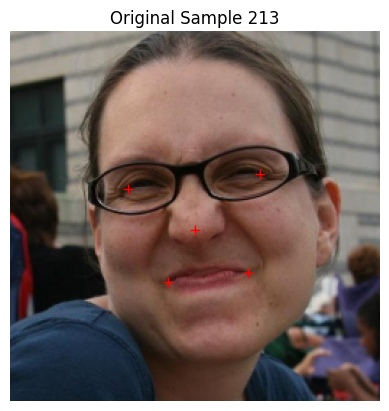

In [ ]:
# Helper Functions
def visualise_pts(img, pts, title=None):
  plt.imshow(img.astype(np.uint8) if img.ndim == 3 else img.astype(np.uint8), cmap='gray' if img.ndim == 2 else None)
  pts_reshaped = pts.reshape(-1, 2)
  plt.plot(pts_reshaped[:, 0], pts_reshaped[:, 1], '+r', markersize=7)
  if title: plt.title(title)
  plt.axis('off'); plt.show()

def euclid_dist(pred_pts, gt_pts): # Calculate Euclidean distance for each landmark point
  return np.sqrt(np.sum(np.square(np.reshape(pred_pts, (-1, 2)) - np.reshape(gt_pts, (-1, 2))), axis=-1))


def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==5*2, 'wrong number of points provided. There should be 5 points with 2 values (x,y) per point'
    # The function internally reshapes to (points.shape[0], -1) before saving
    np.savetxt(location + '/results_task2.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')
    print(f"Test predictions saved to {location}/results_task2.csv")

idx = np.random.randint(0, images_train_orig.shape[0])
visualise_pts(images_train_orig[idx], pts_train_orig[idx], title=f"Original Sample {idx}")

# Preprocessing and Validation HOG

**Markdown:**

 This cell defines functions to preprocess and augment images specifically for the HOG feature pipeline.
 - Images are converted to grayscale, resized to 96x96.
 - Augmentation involves random horizontal flips and random brightness/contrast adjustments.
 - The output images are normalized to float [0,1] as expected by skimage.feature.hog.
 The training dataset is then processed to create an augmented set (doubling its size).
 Test images are also preprocessed without augmentation.



--- HOG PIPELINE: 1. Image Preprocessing & Augmentation ---
Preprocessing & Augmenting training images for HOG (creating original + augmented versions)...
Preprocessing test images for HOG...
Processed HOG training images shape: (5622, 96, 96)
HOG Target training points reshaped: (5622, 10)


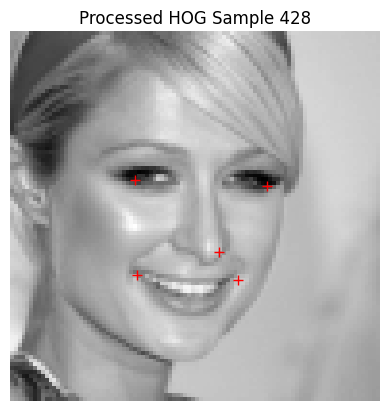

In [ ]:
# Image Preprocessing & Augmentation for HOG
print("\n--- HOG PIPELINE: 1. Image Preprocessing & Augmentation ---")

# Target dimensions for HOG feature extraction
IMG_RESIZE_H_HOG, IMG_RESIZE_W_HOG = 96, 96
ORIG_H, ORIG_W = 256, 256
FLIP_PAIRS = {0: 1, 1: 0, 3: 4, 4: 3}


def preprocess_augment_train_hog(img_rgb, pts_orig, target_h, target_w, augment_flip=True, augment_brightness=True):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    if augment_brightness and np.random.rand() > 0.5:
        alpha = np.random.uniform(0.7, 1.3) # Contrast factor
        beta = np.random.randint(-20, 21) #Brighteness offset
        img_gray = cv2.convertScaleAbs(img_gray, alpha=alpha, beta=beta) # Applies adjustment

    original_h_gray, original_w_gray = img_gray.shape # Shape before resize
    img_resized = cv2.resize(img_gray, (target_w, target_h), interpolation=cv2.INTER_AREA)

    # Scale landmark points to resized image dimesnions
    pts_scaled = pts_orig.copy().astype(np.float32)
    scale_x = target_w / original_w_gray; scale_y = target_h / original_w_gray
    pts_scaled[:, 0] *= scale_x; pts_scaled[:, 1] *= scale_y

    if augment_flip and np.random.rand() > 0.5: #Aplying random flip to the image
        img_resized = cv2.flip(img_resized, 1)
        pts_scaled[:, 0] = target_w - pts_scaled[:, 0]
        new_pts_order = pts_scaled.copy()
        for left_idx, right_idx in FLIP_PAIRS.items(): new_pts_order[left_idx] = pts_scaled[right_idx]
        pts_scaled = new_pts_order

    img_normalized_float = img_resized.astype(np.float32) / 255.0 # Normalize for float
    return img_normalized_float, pts_scaled

def preprocess_test_hog(img_rgb, target_h, target_w):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    img_resized = cv2.resize(img_gray, (target_w, target_h), interpolation=cv2.INTER_AREA)
    img_normalized_float = img_resized.astype(np.float32) / 255.0
    return img_normalized_float

num_orig_train = images_train_orig.shape[0] # From Cell 1 of SIFT notebook
processed_images_list_hog = []
processed_pts_list_hog = []

print("Preprocessing & Augmenting training images for HOG (creating original + augmented versions)...")
np.random.seed(42)


for i in range(num_orig_train):
    # 1. Original processed
    img_proc_orig, pts_proc_orig = preprocess_augment_train_hog(
        images_train_orig[i], pts_train_orig[i], IMG_RESIZE_H_HOG, IMG_RESIZE_W_HOG,
        augment_flip=False, augment_brightness=False)
    processed_images_list_hog.append(img_proc_orig)
    processed_pts_list_hog.append(pts_proc_orig)

    # 2. Augmented version
    img_aug, pts_aug = preprocess_augment_train_hog(
        images_train_orig[i], pts_train_orig[i], IMG_RESIZE_H_HOG, IMG_RESIZE_W_HOG,
        augment_flip=True, augment_brightness=True)
    processed_images_list_hog.append(img_aug)
    processed_pts_list_hog.append(pts_aug)

#Converts lists into arrays
images_train_processed_hog = np.array(processed_images_list_hog)
pts_train_processed_hog = np.array(processed_pts_list_hog)

num_test = images_test_orig.shape[0]
images_test_processed_hog = np.empty((num_test, IMG_RESIZE_H_HOG, IMG_RESIZE_W_HOG), dtype=np.float32)
print("Preprocessing test images")
for i in range(num_test):
    images_test_processed_hog[i] = preprocess_test_hog(
        images_test_orig[i], IMG_RESIZE_H_HOG, IMG_RESIZE_W_HOG)

#Reshape training points ro be flat for regression model
y_train_flat_hog = pts_train_processed_hog.reshape(images_train_processed_hog.shape[0], -1)
print(f"Processed HOG training images shape: {images_train_processed_hog.shape}")
print(f"HOG Target training points reshaped: {y_train_flat_hog.shape}")

#Visualise random sample for the preprocessed data set
idx_hog = np.random.randint(0, images_train_processed_hog.shape[0])
visualise_pts(images_train_processed_hog[idx_hog]*255, pts_train_processed_hog[idx_hog], title=f"Processed HOG Sample {idx_hog}")

# HOG Feature Extraction

**Markdwon**

This cell defines parameters for HOG feature extraction and applies it to the
 preprocessed training and test images.

 The HOG parameters (orientations, pixels_per_cell, cells_per_block) are crucial
 and were chosen based on common practice and to match details from the report's abstract  that indicated a high-dimensional HOG feature (23k).

 No PCA is applied to HOG features in this notebook version for the HOG pipeline.

In [ ]:
# HOG Feature Extraction
print("\n--- HOG PIPELINE: 2. HOG Feature Extraction ---")
from skimage.feature import hog # Make sure it's imported

# HOG Parameters (Crucial for performance - these are examples, tune them)
ORIENTATIONS = 9
PIXELS_PER_CELL = (5, 5)
CELLS_PER_BLOCK = (3, 3)
BLOCK_NORM = 'L2-Hys'
TRANSFORM_SQRT = True # Often improves HOG performance

def extract_hog_features_single(image_float, orientations, pixels_per_cell, cells_per_block, block_norm, transform_sqrt):
    features = hog(image_float, orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   block_norm=block_norm,
                   transform_sqrt=transform_sqrt,
                   feature_vector=True) # Ensure a flat vector
    return features

# Determine HOG feature dimension from one sample
sample_hog_feats = extract_hog_features_single(images_train_processed_hog[0], ORIENTATIONS, PIXELS_PER_CELL, CELLS_PER_BLOCK, BLOCK_NORM, TRANSFORM_SQRT)
HOG_FEATURE_DIM = sample_hog_feats.shape[0]
print(f"HOG Feature Dimension: {HOG_FEATURE_DIM}")

print(f"Extracting HOG features for training images (PPC={PIXELS_PER_CELL}, CPB={CELLS_PER_BLOCK})...")
features_train_hog_list = [extract_hog_features_single(img, ORIENTATIONS, PIXELS_PER_CELL, CELLS_PER_BLOCK, BLOCK_NORM, TRANSFORM_SQRT) for img in images_train_processed_hog]
features_train_hog = np.array(features_train_hog_list) # COnvert list of features into numpy array

features_test_hog_list = [extract_hog_features_single(img, ORIENTATIONS, PIXELS_PER_CELL, CELLS_PER_BLOCK, BLOCK_NORM, TRANSFORM_SQRT) for img in images_test_processed_hog]
features_test_hog = np.array(features_test_hog_list)

print(f"HOG Training features shape: {features_train_hog.shape}") # Expected: (5622, 23409)
print(f"HOG Test features shape: {features_test_hog.shape}")  # Expected: (554, 23409)


features_train_hog_processed = features_train_hog
features_test_hog_processed = features_test_hog


--- HOG PIPELINE: 2. HOG Feature Extraction ---
HOG Feature Dimension: 23409
Extracting HOG features for training images (PPC=(5, 5), CPB=(3, 3))...
HOG Training features shape: (5622, 23409)
HOG Test features shape: (554, 23409)


# Model Treaining and Validation HOG

**Markdown:**

This cell splits the HOG features and corresponding labels into training and validation sets.

 It then defines a Ridge regression model and uses GridSearchCV to find the optimal 'alpha' (regularization strength) parameter using 5-fold cross-validation on the training portion.

The best model is then used to make predictions on the validation set.

In [ ]:
# Model Training & Validation (HOG + Ridge)
print("\n--- HOG PIPELINE: 3. Model Training & Validation (HOG + Ridge) ---")
# Full augmented HOG training features
X_train_hog_val, X_val_hog_val, y_train_hog_reg, y_val_hog_true_flat = train_test_split(
    features_train_hog_processed, y_train_flat_hog, test_size=0.2, random_state=42) # Using HOG specific data

print(f"HOG Training features shape for Ridge: {X_train_hog_val.shape}")
print(f"HOG Validation features shape for Ridge: {X_val_hog_val.shape}")

ridge_model_hog = Ridge(random_state=42)
param_grid_ridge_hog = {'alpha': [ 1.0, 10.0, 50.0, 100.0]} # HOG features might need different alpha
grid_search_ridge_hog = GridSearchCV(ridge_model_hog, param_grid_ridge_hog, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge_hog.fit(X_train_hog_val, y_train_hog_reg)
best_ridge_model_hog = grid_search_ridge_hog.best_estimator_  # Get the best Ridge model with the optimal alpha.
print(f"Best Ridge alpha for HOG features: {best_ridge_model_hog.alpha}")

y_val_pred_flat_hog = best_ridge_model_hog.predict(X_val_hog_val)
y_val_pred_pts_hog = y_val_pred_flat_hog.reshape(y_val_pred_flat_hog.shape[0], 5, 2)
y_val_true_pts_hog = y_val_hog_true_flat.reshape(y_val_hog_true_flat.shape[0], 5, 2)


--- HOG PIPELINE: 3. Model Training & Validation (HOG + Ridge) ---
HOG Training features shape for Ridge: (4497, 23409)
HOG Validation features shape for Ridge: (1125, 23409)
Best Ridge alpha for HOG features: 50.0


# Evaluation on Validation Set HOG

**Markdown**

This cell evaluates the performance of the tuned HOG+Ridge model on the validation set.
 1. Calculates Mean Euclidean Error (MEE) per landmark and overall, scaled to original image resolution.
 2. Calculates Inter-Ocular Distance (IOD) normalized errors.
 3. Generates and plots the Cumulative Error Distribution (CED) curve for pixel errors.



--- HOG PIPELINE: 4. Evaluation on Validation Set (HOG Model) ---
HOG Model - Overall mean Euclidean error on validation set (scaled to original 256x256 image): 4.11 pixels
  Landmark 0: 2.91 pixels
  Landmark 1: 2.89 pixels
  Landmark 2: 5.30 pixels
  Landmark 3: 4.63 pixels
  Landmark 4: 4.81 pixels

--- HOG Model - IOD Normalised Errors (on 96x96 scale before IOD division) ---
Mean normalised error (HOG+Ridge):    0.04275
Median normalised error (HOG+Ridge):  0.03463
% < 0.05 IOD                       :   69.1%
% < 0.10 IOD                       :   94.3%


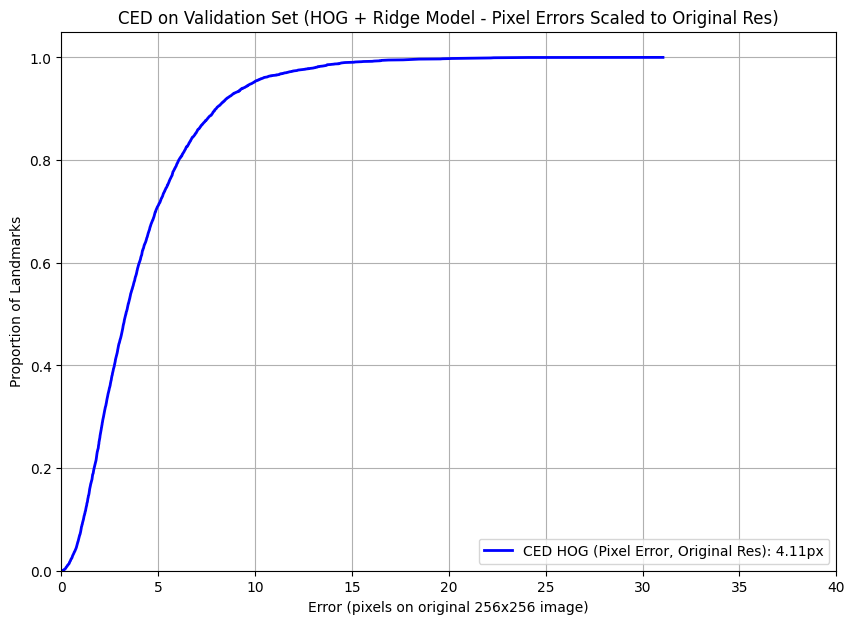

In [ ]:
# Cell HOG_4: Evaluation on Validation Set (HOG Model)
print("\n--- HOG PIPELINE: 4. Evaluation on Validation Set (HOG Model) ---")
errors_val_pixels_resized_hog = np.array([euclid_dist(y_val_pred_pts_hog[i], y_val_true_pts_hog[i]) for i in range(y_val_true_pts_hog.shape[0])])
avg_error_scale_factor_hog = (ORIG_W / IMG_RESIZE_W_HOG + ORIG_H / IMG_RESIZE_H_HOG) / 2.0
errors_val_pixels_orig_res_hog = errors_val_pixels_resized_hog * avg_error_scale_factor_hog
mean_error_per_landmark_orig_res_hog = np.mean(errors_val_pixels_orig_res_hog, axis=0)
overall_mean_error_orig_res_hog = np.mean(errors_val_pixels_orig_res_hog)
print(f"HOG Model - Overall mean Euclidean error on validation set (scaled to original {ORIG_W}x{ORIG_H} image): {overall_mean_error_orig_res_hog:.2f} pixels")
for i in range(mean_error_per_landmark_orig_res_hog.shape[0]): print(f"  Landmark {i}: {mean_error_per_landmark_orig_res_hog[i]:.2f} pixels")

# IOD Normalised Errors for HOG
# Calculate IOD for each validation image (distance between ground truth eye centers on 96x96 scale).
iod_val_list_hog = []
for i in range(y_val_true_pts_hog.shape[0]):
    left_eye_true = y_val_true_pts_hog[i, 0, :]; right_eye_true = y_val_true_pts_hog[i, 1, :]
    iod = np.sqrt(np.sum(np.square(left_eye_true - right_eye_true)))
    iod_val_list_hog.append(iod if iod > 1e-6 else 1e-6)
iod_val_hog = np.array(iod_val_list_hog)
errors_val_normalised_by_iod_hog = errors_val_pixels_resized_hog / iod_val_hog[:, np.newaxis]
err_hog_normalised_flat = errors_val_normalised_by_iod_hog.flatten()
print(f"\n--- HOG Model - IOD Normalised Errors (on {IMG_RESIZE_W_HOG}x{IMG_RESIZE_H_HOG} scale before IOD division) ---")
print(f"Mean normalised error (HOG+Ridge):    {err_hog_normalised_flat.mean():.5f}")
print(f"Median normalised error (HOG+Ridge):  {np.median(err_hog_normalised_flat):.5f}")
print(f"% < 0.05 IOD                       :   {100*(err_hog_normalised_flat < 0.05).mean():.1f}%")
print(f"% < 0.10 IOD                       :   {100*(err_hog_normalised_flat < 0.10).mean():.1f}%")

# CED Curve (Pixel Errors for HOG)
# Flatten all landmark pixel errors (original resolution) and sort for CED plot.
all_landmark_errors_orig_res_flat_hog = errors_val_pixels_orig_res_hog.flatten()
df_errors_ced_hog = pd.DataFrame({'error': np.sort(all_landmark_errors_orig_res_flat_hog)})
df_errors_ced_hog['proportion'] = np.arange(1, len(df_errors_ced_hog) + 1) / float(len(df_errors_ced_hog))
plt.figure(figsize=(10, 7)); plt.plot(df_errors_ced_hog['error'], df_errors_ced_hog['proportion'],
         label=f'CED HOG (Pixel Error, Original Res): {overall_mean_error_orig_res_hog:.2f}px', color='blue', lw=2)
plt.title('CED on Validation Set (HOG + Ridge Model - Pixel Errors Scaled to Original Res)')
plt.xlabel(f'Error (pixels on original {ORIG_W}x{ORIG_H} image)'); plt.ylabel('Proportion of Landmarks')
plt.grid(True); plt.legend(); plt.xlim(0, 40); plt.ylim(0, 1.05); plt.show()




# Test Set and Prediction Saving

 **Markdown**

 This cell takes the best HOG+Ridge model (alpha=50), retrains it on the *entire* augmented training dataset (5622 samples), and then uses this final model to predict landmarks on the processed test images.

 The predictions are scaled back to the original 256x256 image resolution.

 One example prediction on a test image is visualized.

 The final saving of these predictions to 'results_task2.csv' will be handledin a separate cell.



--- HOG PIPELINE: 5. Prediction on Test Set & Saving (HOG Model) ---
Re-training HOG+Ridge model (alpha=50.0) on FULL HOG training dataset...
Predicting on test set HOG features...
Test predictions (HOG) scaled to original resolution: (554, 5, 2)
Visualizing one HOG+Ridge prediction on an original test image:


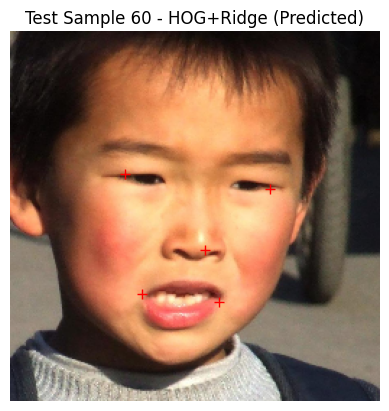

In [ ]:
# Test Set Prediction & Saving (HOG Model)
print("\n--- HOG PIPELINE: 5. Prediction on Test Set & Saving (HOG Model) ")
print(f"Re-training HOG+Ridge model (alpha={best_ridge_model_hog.alpha}) on FULL HOG training dataset")
final_model_hog = Ridge(alpha=best_ridge_model_hog.alpha, random_state=42)
final_model_hog.fit(features_train_hog_processed, y_train_flat_hog)
# Retrain the best HOG Ridge model on the FULL processed HOG training dataset (augmented).

print("Predicting on test set HOG features...")
y_test_pred_flat_hog = final_model_hog.predict(features_test_hog_processed)
y_test_pred_pts_resized_hog = y_test_pred_flat_hog.reshape(images_test_orig.shape[0], 5, 2)

y_test_pred_pts_orig_res_hog = y_test_pred_pts_resized_hog.copy()
y_test_pred_pts_orig_res_hog[:, :, 0] *= (ORIG_W / IMG_RESIZE_W_HOG)
y_test_pred_pts_orig_res_hog[:, :, 1] *= (ORIG_H / IMG_RESIZE_H_HOG)
print(f"Test predictions (HOG) scaled to original resolution: {y_test_pred_pts_orig_res_hog.shape}")

print("Visualizing one HOG+Ridge prediction on an original test image:")
idx_test_viz_hog = np.random.randint(0, images_test_orig.shape[0])
visualise_pts(images_test_orig[idx_test_viz_hog], y_test_pred_pts_orig_res_hog[idx_test_viz_hog], title=f"Test Sample {idx_test_viz_hog} - HOG+Ridge (Predicted)")


In [ ]:
# Save Test Set Predictions for Task 2 Submission


final_task2_predictions = y_test_pred_pts_orig_res_hog
save_as_csv(final_task2_predictions, location='.')

Test predictions saved to ./results_task2.csv


# Preprocessing and Augementation SIFT

--- 1. Image Preprocessing & Augmentation (Enlarging Dataset) ---
Preprocessing & Augmenting training images (creating original + augmented versions)...
Preprocessing test images for SIFT...
Processed training images shape (now enlarged): (5622, 96, 96)
Target training points reshaped (y_train_flat): (5622, 10)
Processed test images shape: (554, 96, 96)


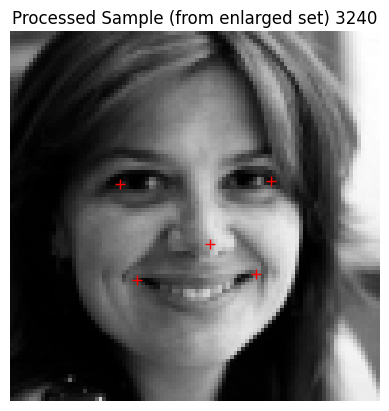

In [ ]:
# Image Preprocessing & Augmentation
print("--- 1. Image Preprocessing & Augmentation (Enlarging Dataset) ---")

IMG_RESIZE_H, IMG_RESIZE_W = 96, 96
ORIG_H, ORIG_W = 256, 256
FLIP_PAIRS = {0: 1, 1: 0, 3: 4, 4: 3}

def _process_single_image_sift_for_augmentation(img_rgb, pts_orig, target_h, target_w,
                                            apply_flip=False, apply_brightness_contrast=False,
                                            random_seed_for_brightness=None): # Seed for brightness consistency if needed
    """Helper to process one image, with controllable augmentation choices."""
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    img_to_resize = img_gray.astype(np.uint8) # Start with uint8

    if apply_brightness_contrast:
        # Ensure brightness augmentation is somewhat consistent if called multiple times for same base image for different aug types
        if random_seed_for_brightness is not None:
            current_random_state = np.random.get_state()
            np.random.seed(random_seed_for_brightness)

        alpha = np.random.uniform(0.7, 1.3) # Contrast
        beta = np.random.randint(-20, 21)    # Brightness
        img_to_resize = cv2.convertScaleAbs(img_gray, alpha=alpha, beta=beta)

        if random_seed_for_brightness is not None:
            np.random.set_state(current_random_state) # Restore random state

    original_h_gray, original_w_gray = img_gray.shape # Use original gray shape for consistent scaling factors
    img_resized_uint8 = cv2.resize(img_to_resize, (target_w, target_h), interpolation=cv2.INTER_AREA)

    pts_scaled = pts_orig.copy().astype(np.float32)
    scale_x = target_w / original_w_gray
    scale_y = target_h / original_h_gray
    pts_scaled[:, 0] *= scale_x; pts_scaled[:, 1] *= scale_y

    if apply_flip:
        img_resized_uint8 = cv2.flip(img_resized_uint8, 1)
        pts_scaled[:, 0] = target_w - pts_scaled[:, 0]
        new_pts_order = pts_scaled.copy()
        for left_idx, right_idx in FLIP_PAIRS.items(): new_pts_order[left_idx] = pts_scaled[right_idx]
        pts_scaled = new_pts_order

    return img_resized_uint8, pts_scaled

# Create Enlarged Training Set ---
num_orig_train = images_train_orig.shape[0]
processed_images_list = []
processed_pts_list = []

print("Preprocessing & Augmenting training images (creating original + augmented versions)...")
np.random.seed(42) # Seed for np.random.uniform/randint used in brightness augmentation for reproducibility


for i in range(num_orig_train):
    # 1. Add original (processed, no flip, no brightness/contrast explicitly for this "base" version)
    img_proc_orig, pts_proc_orig = _process_single_image_sift_for_augmentation(
        images_train_orig[i], pts_train_orig[i], IMG_RESIZE_H, IMG_RESIZE_W,
        apply_flip=False, apply_brightness_contrast=False
    )
    processed_images_list.append(img_proc_orig)
    processed_pts_list.append(pts_proc_orig)

    # 2. Add an augmented version (e.g., flipped AND brightness/contrast change)
    # Using a different seed for brightness here or making it deterministic per image ensures variation
    # For simplicity, using the global np.random state is fine due to overall seeding.
    img_aug_flipped_bright, pts_aug_flipped_bright = _process_single_image_sift_for_augmentation(
        images_train_orig[i], pts_train_orig[i], IMG_RESIZE_H, IMG_RESIZE_W,
        apply_flip=True, apply_brightness_contrast=True
    )
    processed_images_list.append(img_aug_flipped_bright)
    processed_pts_list.append(pts_aug_flipped_bright)

images_train_processed = np.array(processed_images_list)
pts_train_processed = np.array(processed_pts_list)
#  End Enlarged Training Set Creation

# Preprocess test images (no augmentation)
num_test = images_test_orig.shape[0]
images_test_processed = np.empty((num_test, IMG_RESIZE_H, IMG_RESIZE_W), dtype=np.uint8)
print("Preprocessing test images for SIFT...")
for i in range(num_test):
    images_test_processed[i], _ = _process_single_image_sift_for_augmentation(
        images_test_orig[i], np.zeros((5,2)), IMG_RESIZE_H, IMG_RESIZE_W,
        apply_flip=False, apply_brightness_contrast=False)

y_train_flat = pts_train_processed.reshape(images_train_processed.shape[0], -1)
print(f"Processed training images shape (now enlarged): {images_train_processed.shape}") # Should be (2 * num_orig_train, H, W)
print(f"Target training points reshaped (y_train_flat): {y_train_flat.shape}")       # Should be (2 * num_orig_train, 10)
print(f"Processed test images shape: {images_test_processed.shape}")

idx = np.random.randint(0, images_train_processed.shape[0])
visualise_pts(images_train_processed[idx], pts_train_processed[idx], title=f"Processed Sample (from enlarged set) {idx}")

# Feature Extraction SIFT

In [ ]:
# SIFT Feature Extraction on a Defined Grid (Optimized Parameters)

print("\n--- 2. SIFT Feature Extraction ---")

SIFT_GRID_ROWS = 10
SIFT_GRID_COLS = 10
SIFT_KP_SIZE = 3
EXPECTED_SIFT_FEATURE_LEN = SIFT_GRID_ROWS * SIFT_GRID_COLS * 128

def extract_sift_on_grid_optimized(image_uint8, grid_rows, grid_cols, kp_size):
    sift_detector = cv2.SIFT_create()
    img_h, img_w = image_uint8.shape
    keypoints = [cv2.KeyPoint(float((img_w/(grid_cols+1))*(c+1)), float((img_h/(grid_rows+1))*(r+1)), float(kp_size))
                 for r in range(grid_rows) for c in range(grid_cols)]
    if not keypoints: return np.zeros(EXPECTED_SIFT_FEATURE_LEN)
    _, descriptors = sift_detector.compute(image_uint8, keypoints)
    if descriptors is None or descriptors.shape[0] != len(keypoints): return np.zeros(EXPECTED_SIFT_FEATURE_LEN)
    return descriptors.flatten()

print(f"Extracting SIFT features (Grid: {SIFT_GRID_ROWS}x{SIFT_GRID_COLS}, KP Size: {SIFT_KP_SIZE})...")
features_train_sift_list = [extract_sift_on_grid_optimized(img, SIFT_GRID_ROWS, SIFT_GRID_COLS, SIFT_KP_SIZE) for img in images_train_processed]
features_train_sift = np.array([d if d.shape[0] == EXPECTED_SIFT_FEATURE_LEN else np.zeros(EXPECTED_SIFT_FEATURE_LEN) for d in features_train_sift_list])

features_test_sift_list = [extract_sift_on_grid_optimized(img, SIFT_GRID_ROWS, SIFT_GRID_COLS, SIFT_KP_SIZE) for img in images_test_processed]
features_test_sift = np.array([d if d.shape[0] == EXPECTED_SIFT_FEATURE_LEN else np.zeros(EXPECTED_SIFT_FEATURE_LEN) for d in features_test_sift_list])

print(f"SIFT Training features shape: {features_train_sift.shape}")
print(f"SIFT Test features shape: {features_test_sift.shape}")

N_PCA_COMPONENTS = 0.99
sift_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=N_PCA_COMPONENTS, random_state=42))
])

print(f"Processing SIFT features with StandardScaler and PCA (n_components retaining {N_PCA_COMPONENTS*100}% variance)...")
features_train_processed = sift_pipeline.fit_transform(features_train_sift)
features_test_processed = sift_pipeline.transform(features_test_sift)
print(f"Processed SIFT Training features shape: {features_train_processed.shape}")
print(f"Processed SIFT Test features shape: {features_test_processed.shape}")


--- 2. SIFT Feature Extraction ---
Extracting SIFT features (Grid: 10x10, KP Size: 3)...
SIFT Training features shape: (5622, 12800)
SIFT Test features shape: (554, 12800)
Processing SIFT features with StandardScaler and PCA (n_components retaining 99.0% variance)...
Processed SIFT Training features shape: (5622, 3252)
Processed SIFT Test features shape: (554, 3252)


# Model Training and Validation SIFT

In [ ]:
#  Model Training & Validation SIFT
print("\n--- 3. Model Training & Validation (SIFT + Ridge) ---")


X_train, X_val, y_train_reg, y_val_true_flat = train_test_split(
    features_train_processed, y_train_flat, test_size=0.2, random_state=42

)

print(f"Training features shape: {X_train.shape}") # Will be 0.8 * (2 * num_orig_train)
print(f"Validation features shape: {X_val.shape}") # Will be 0.2 * (2 * num_orig_train)

ridge_model = Ridge(random_state=42)
# Alpha=4300 was optimal for your previous dataset size. With more data, optimal alpha might decrease.
# It's crucial to re-tune with GridSearchCV.
param_grid_ridge = {'alpha': [1.0, 10.0, 100.0, 1000.0, 5000.0, 10000.0]} # Hyperparameter Tunung
grid_search_ridge = GridSearchCV(ridge_model, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train, y_train_reg)
best_ridge_model = grid_search_ridge.best_estimator_
print(f"Best Ridge alpha for SIFT features (on enlarged data): {best_ridge_model.alpha}")

y_val_pred_flat = best_ridge_model.predict(X_val)
y_val_pred_pts = y_val_pred_flat.reshape(y_val_pred_flat.shape[0], 5, 2)
y_val_true_pts = y_val_true_flat.reshape(y_val_true_flat.shape[0], 5, 2)


--- 3. Model Training & Validation (SIFT + Ridge) ---
Training features shape: (4497, 3252)
Validation features shape: (1125, 3252)
Best Ridge alpha for SIFT features (on enlarged data): 10000.0


# Evaluation and Validation SIFT


--- 4. Evaluation on Validation Set (SIFT Model - Trained on Enlarged Data) ---
Overall mean Euclidean error on validation set (scaled to original 256x256 image): 4.76 pixels
  Landmark 0 (scaled to original res): 3.21 pixels
  Landmark 1 (scaled to original res): 3.32 pixels
  Landmark 2 (scaled to original res): 6.18 pixels
  Landmark 3 (scaled to original res): 5.52 pixels
  Landmark 4 (scaled to original res): 5.55 pixels

--- IOD Normalised Errors (on 96x96 scale before IOD division) ---
Mean normalised error (SIFT+Ridge):    0.04954
Median normalised error (SIFT+Ridge):  0.04053
% < 0.05 IOD                       :   61.2%
% < 0.10 IOD                       :   91.4%


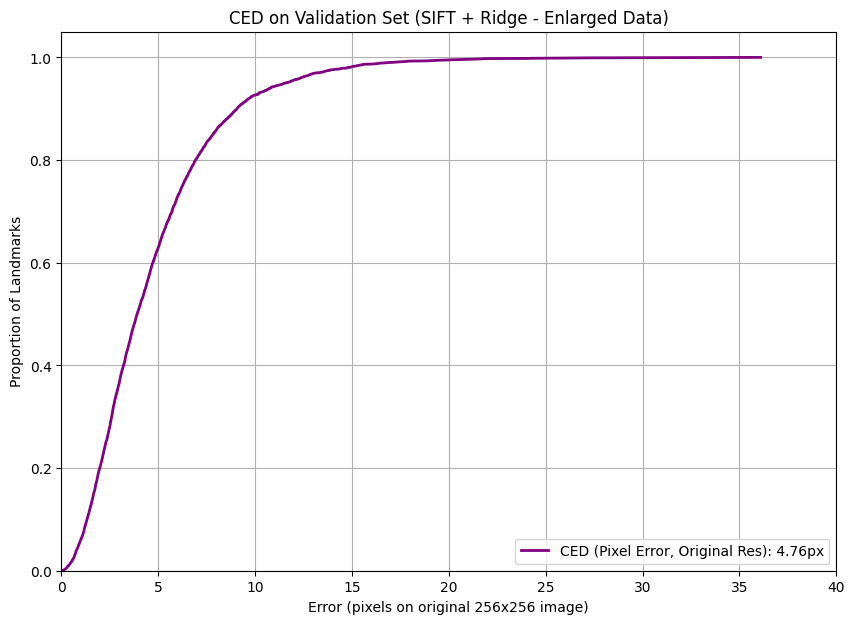

Visualizing SIFT+Ridge predictions on PROCESSED validation images (from enlarged set):


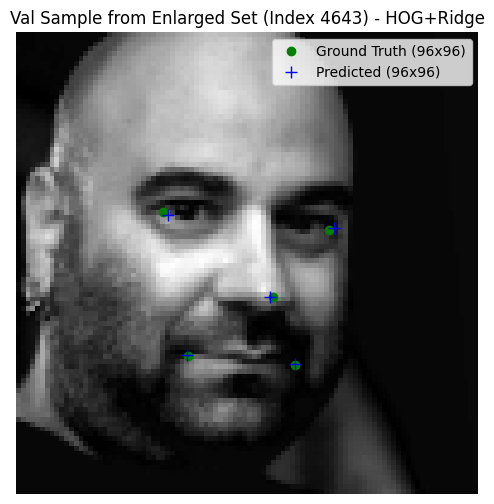

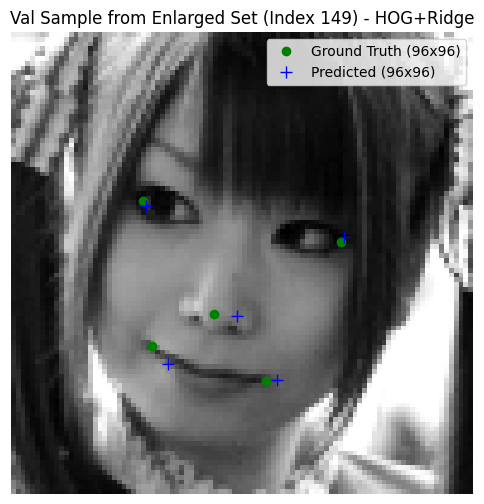

In [ ]:
# Evaluation on Validation Set (SIFT Model)
print("\n--- 4. Evaluation on Validation Set (SIFT Model - Trained on Enlarged Data) ---")
errors_val_pixels_resized = np.array([euclid_dist(y_val_pred_pts[i], y_val_true_pts[i]) for i in range(y_val_true_pts.shape[0])])
avg_error_scale_factor = (ORIG_W / IMG_RESIZE_W + ORIG_H / IMG_RESIZE_H) / 2.0
errors_val_pixels_orig_res = errors_val_pixels_resized * avg_error_scale_factor
mean_error_per_landmark_orig_res = np.mean(errors_val_pixels_orig_res, axis=0)
overall_mean_error_orig_res = np.mean(errors_val_pixels_orig_res)
print(f"Overall mean Euclidean error on validation set (scaled to original {ORIG_W}x{ORIG_H} image): {overall_mean_error_orig_res:.2f} pixels")
for i in range(mean_error_per_landmark_orig_res.shape[0]): print(f"  Landmark {i} (scaled to original res): {mean_error_per_landmark_orig_res[i]:.2f} pixels")

# IOD Normalised Errors
iod_val_list = []
# y_val_true_pts are already predictions on the validation set (which came from the enlarged processed set)
for i in range(y_val_true_pts.shape[0]):
    left_eye_true = y_val_true_pts[i, 0, :]; right_eye_true = y_val_true_pts[i, 1, :]
    iod = np.sqrt(np.sum(np.square(left_eye_true - right_eye_true)))
    iod_val_list.append(iod if iod > 1e-6 else 1e-6)
iod_val = np.array(iod_val_list)
errors_val_normalised_by_iod = errors_val_pixels_resized / iod_val[:, np.newaxis]
err_sift_normalised_flat = errors_val_normalised_by_iod.flatten()
print(f"\n--- IOD Normalised Errors (on {IMG_RESIZE_W}x{IMG_RESIZE_H} scale before IOD division) ---")
print(f"Mean normalised error (SIFT+Ridge):    {err_sift_normalised_flat.mean():.5f}")
print(f"Median normalised error (SIFT+Ridge):  {np.median(err_sift_normalised_flat):.5f}")
print(f"% < 0.05 IOD                       :   {100*(err_sift_normalised_flat < 0.05).mean():.1f}%")
print(f"% < 0.10 IOD                       :   {100*(err_sift_normalised_flat < 0.10).mean():.1f}%")

# CED Curve (Pixel Errors)
all_landmark_errors_orig_res_flat = errors_val_pixels_orig_res.flatten()
df_errors_ced = pd.DataFrame({'error': np.sort(all_landmark_errors_orig_res_flat)})
df_errors_ced['proportion'] = np.arange(1, len(df_errors_ced) + 1) / float(len(df_errors_ced))
plt.figure(figsize=(10, 7)); plt.plot(df_errors_ced['error'], df_errors_ced['proportion'],
         label=f'CED (Pixel Error, Original Res): {overall_mean_error_orig_res:.2f}px', color='purple', lw=2)
plt.title('CED on Validation Set (SIFT + Ridge - Enlarged Data)'); plt.xlabel(f'Error (pixels on original {ORIG_W}x{ORIG_H} image)')
plt.ylabel('Proportion of Landmarks'); plt.grid(True); plt.legend(); plt.xlim(0, 40); plt.ylim(0, 1.05); plt.show()

print("Visualizing SIFT+Ridge predictions on PROCESSED validation images (from enlarged set):")

all_indices_enlarged = np.arange(images_train_processed.shape[0])
_, val_indices_enlarged_for_viz = train_test_split(all_indices_enlarged, test_size=0.2, random_state=42)


for _ in range(min(2, X_val.shape[0])):
    plot_idx_in_val_set = np.random.choice(X_val.shape[0]) # Pick a random index from the validation set itself


    actual_image_index_in_enlarged_set = val_indices_enlarged_for_viz[plot_idx_in_val_set]

    img_to_show = images_train_processed[actual_image_index_in_enlarged_set] # This is a 96x96 uint8 image
    true_pts_to_show_resized = y_val_true_pts[plot_idx_in_val_set] # 96x96 scale
    pred_pts_to_show_resized = y_val_pred_pts[plot_idx_in_val_set] # 96x96 scale

    plt.figure(figsize=(6,6)); plt.imshow(img_to_show, cmap='gray') # Display the 96x96 processed image
    plt.plot(true_pts_to_show_resized[:, 0], true_pts_to_show_resized[:, 1], 'og', ms=6, label='Ground Truth (96x96)')
    plt.plot(pred_pts_to_show_resized[:, 0], pred_pts_to_show_resized[:, 1], '+b', ms=9, label='Predicted (96x96)')
    plt.title(f'Val Sample from Enlarged Set (Index {actual_image_index_in_enlarged_set}) - HOG+Ridge'); plt.legend(); plt.axis('off'); plt.show()

# Test Set Prediction and Saving SIFT

In [ ]:
# Test Set Prediction & Saving (SIFT Model)
# (This cell remains IDENTICAL to your task2_best_final (3).ipynb Cell 6)
# It will use best_ridge_model trained on the enlarged data from Cell 4
print("\n--- 5. Prediction on Test Set & Saving (SIFT Model - Trained on Enlarged Data) ---")
print(f"Re-training Ridge model (alpha={best_ridge_model.alpha}) on FULL SIFT training dataset (enlarged)...")
final_model_sift = Ridge(alpha=best_ridge_model.alpha, random_state=42)
# features_train_processed and y_train_flat are now from the enlarged dataset
final_model_sift.fit(features_train_processed, y_train_flat)

print("Predicting on test set SIFT features...")
# features_test_processed are from Cell 3 (PCA on test SIFT features)
y_test_pred_flat_sift = final_model_sift.predict(features_test_processed)
y_test_pred_pts_resized_sift = y_test_pred_flat_sift.reshape(images_test_orig.shape[0], 5, 2)

y_test_pred_pts_orig_res_sift = y_test_pred_pts_resized_sift.copy()
y_test_pred_pts_orig_res_sift[:, :, 0] *= (ORIG_W / IMG_RESIZE_W)
y_test_pred_pts_orig_res_sift[:, :, 1] *= (ORIG_H / IMG_RESIZE_H)
print(f"Test predictions (SIFT) scaled to original resolution: {y_test_pred_pts_orig_res_sift.shape}")

print("Visualizing one SIFT+Ridge prediction on an original test image:")
idx_test_viz = np.random.randint(0, images_test_orig.shape[0])
visualise_pts(images_test_orig[idx_test_viz], y_test_pred_pts_orig_res_sift[idx_test_viz], title=f"Test Sample {idx_test_viz} - SIFT+Ridge (Predicted)")

print("\n--- End of Optimized SIFT + Ridge Model (with Enlarged Dataset) ---")